# Bayesian Change Point Detection

This notebook showcases a new experiment, the ``ChangePointDetection`` class in CausalPy : it supports some models that can infer the treatment time directly from the data.

We illustrate this using a built-in model from the CausalPy library, which only requires specifying the effect of the intervention. From this, the model estimates when the intervention likely occurred.

In [1]:
# Imports ...

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

seed = 0

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\pymc_extras\model\marginal\graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


### Using the `InterventionTimeEstimator` PyMC model

The `InterventionTimeEstimator` is designed to infer *when* an intervention likely occurred, based on the **type of effect** you expect it to have produced.  

Instead of specifying the exact time of change, you describe the expected *form* of the intervention: a sudden jump (`level`), a gradual shift (`trend`), or a short-lived anomaly (`impulse`). Optionally, you can narrow the search by providing a plausible time window.  

Under the hood, the model evaluates candidate intervention points and estimates how well each one explains the observed data through Bayesian inference. At its core, it relies on a linear regression, to which the intervention effects are added:  

$$
\begin{align}
\beta &\sim \mathcal{N}(0, 5) \\
\sigma &\sim \text{HalfNormal}(1) \\
\mu &= X \cdot \beta \\
y &\sim \mathcal{N}(\mu, \sigma)
\end{align}
$$

Also, in the next example, the intervention time will not be implicit. Instead, it is treated as a parameter to be inferred within a plausible window. The model then learns which value of $t$ within this range best explains the observed data :

$$
t \sim \mathcal{U}(\text{time range})
$$

#### Example 1: Level Change

In this example, we apply the `InterventionTimeEstimator` model to an Interrupted Time Series in its simplest form: a **level change**.  

A level change corresponds to a sudden shift in the mean level of the series, occurring at the time of the intervention. In this case, the model can be expressed as:

$$
\begin{align}
\text{level} &\sim \mathcal{N}(0, 5) \\
\mu_{\text{level}} &= \sigma(t) \cdot \text{level} \\
y &\sim \mathcal{N}(\mu + \mu_{\text{level}}, \sigma)
\end{align}
$$

where $\sigma(t) = \frac{1}{1 + e^{-t}}$ is the logistic sigmoid function that encodes the timing of the intervention.


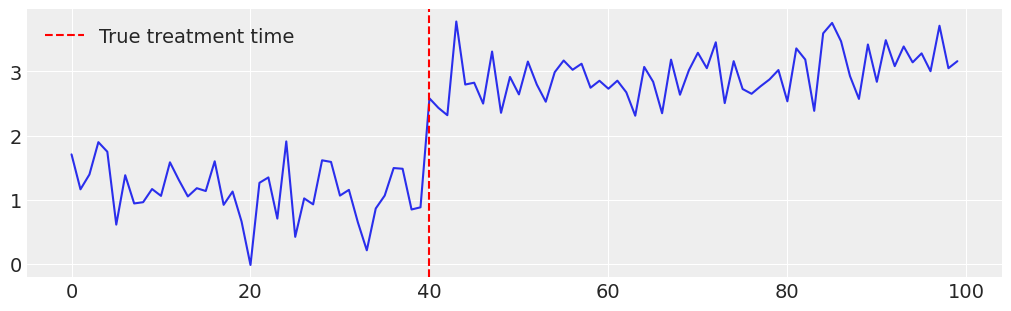

In [2]:
# Generate the Data ...
np.random.seed(seed)

n = 100
tau_true = 40
x = np.arange(n)
y = np.where(x >= tau_true, 2, 0.0) + np.random.normal(1, 0.4, size=n)
df = pd.DataFrame({"t": x, "y": y})

plt.figure(figsize=(10, 3))
plt.plot(x, y)
plt.axvline(tau_true, color="red", linestyle="--", label="True treatment time")
plt.legend();

Now, when initializing the InterventionTimeEstimator model, we only need to  Ensure that InterruptedTimeSeries ``treatment_effect_type`` includes the key ``"level"``. After that, the model can be used as is with the ``InterruptedTimeSeries`` class by setting the ``treatment_time`` parameter to ``None``.

In [3]:
from causalpy.experiments.change_point_detection import ChangePointDetection
from causalpy.pymc_models import LinearChangePointDetection

In [4]:
model = LinearChangePointDetection(
    cp_effect_type="level", sample_kwargs={"sample_seed": seed, "progressbar": False}
)

result = ChangePointDetection(
    data=df,
    time_range=None,
    formula="standardize(y) ~ 1 + t",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, level, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
Sampling: [beta, level, tau_un, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


Finally, this example produces two plots.

The first displays three graphs: 
- the **model’s predictions**, showing both the fitted curve *with* and *without* the inferred causal effect, 
- the **estimated causal impact** which isolates the effect by removing it from the predictions,
- and the **cumulative impact over time**.

The second plot shows the posterior distribution of the inferred treatment time.

:::{note} that the R² score is computed using the full predictions, that is, including the causal effect. In contrast, the causal impact is calculated by subtracting the estimated effect from the predictions.:::

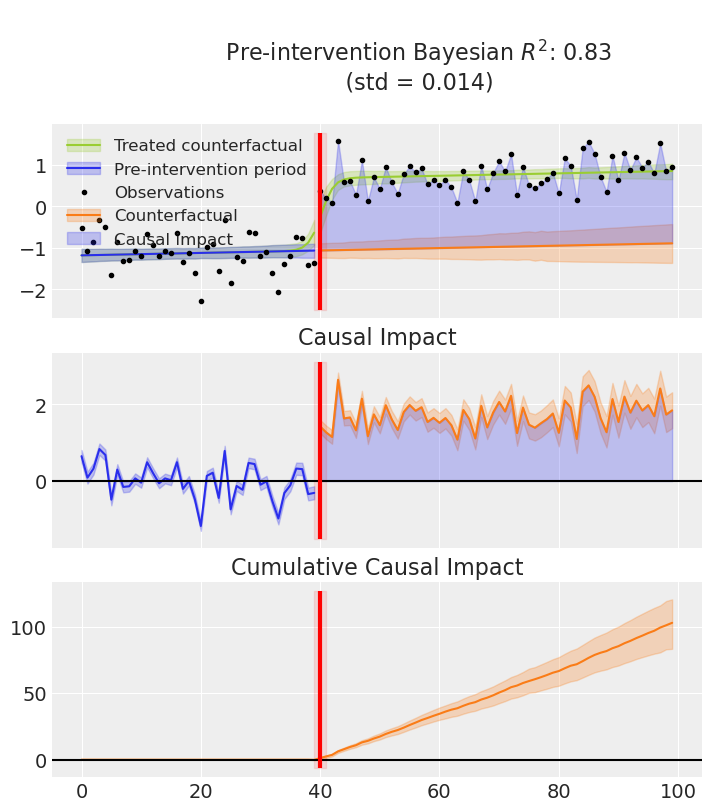

In [5]:
result.plot();

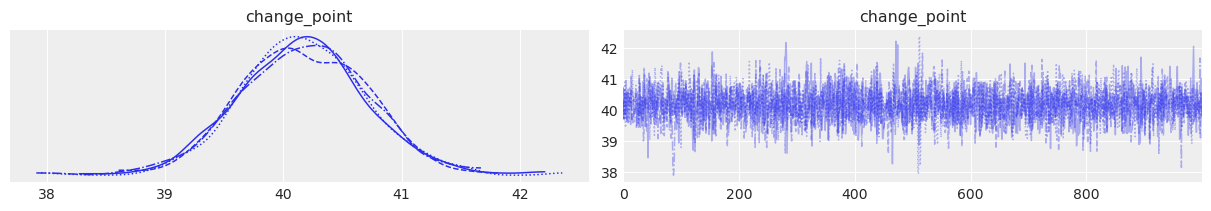

In [6]:
result.plot_change_point()

#### Example 2 : Trend Change

In this example, we illustrate how to use the `InterventionTimeEstimator` when the time series exhibits a **trend change**.  

A trend change corresponds to a gradual shift in the slope of the series starting at the intervention time. The model can be expressed as:

$$
\begin{align}
\text{trend} &\sim \mathcal{N}(0, 0.5) \\
\mu_{\text{trend}} &= \sigma(t) \cdot \text{trend} \cdot (\text{time} - t) \\
y &\sim \mathcal{N}(\mu + \mu_{\text{trend}}, \sigma)
\end{align}
$$

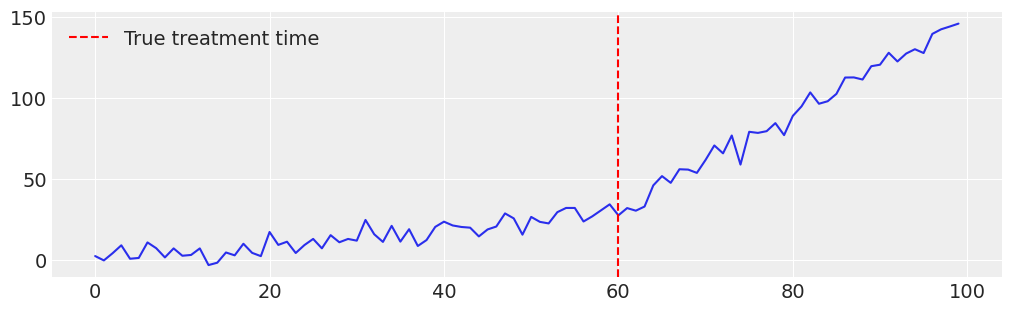

In [7]:
# Generate the data ...
# Set random seed for reproducibility
np.random.seed(42)

n = 100
intervention_point = 60
time = np.arange(n)

pre_trend = 0.5 * time[:intervention_point] + np.random.normal(
    scale=5, size=intervention_point
)
post_trend = (
    0.5 * time[intervention_point]
    + 3.0 * (time[intervention_point:] - time[intervention_point])
    + np.random.normal(scale=5, size=n - intervention_point)
)

synthetic_series = np.concatenate([pre_trend, post_trend])

# Create DataFrame
df = pd.DataFrame({"time": time, "y": synthetic_series})

# Plot
plt.figure(figsize=(10, 3))
plt.plot(df["time"], df["y"])
plt.axvline(
    x=intervention_point, color="red", linestyle="--", label="True treatment time"
)
plt.legend()
plt.grid(True)
plt.show();

Compared to the previous example, the only change is that we use ``"trend"`` instead of ``"level"`` for the ``treatment_effect_type``, to model a change in slope rather than a level shift.

In [8]:
model = LinearChangePointDetection(
    cp_effect_type="trend",
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result = ChangePointDetection(
    data=df,
    time_range=None,
    formula="standardize(y) ~ 1 + time",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, trend, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
Sampling: [beta, tau_un, trend, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


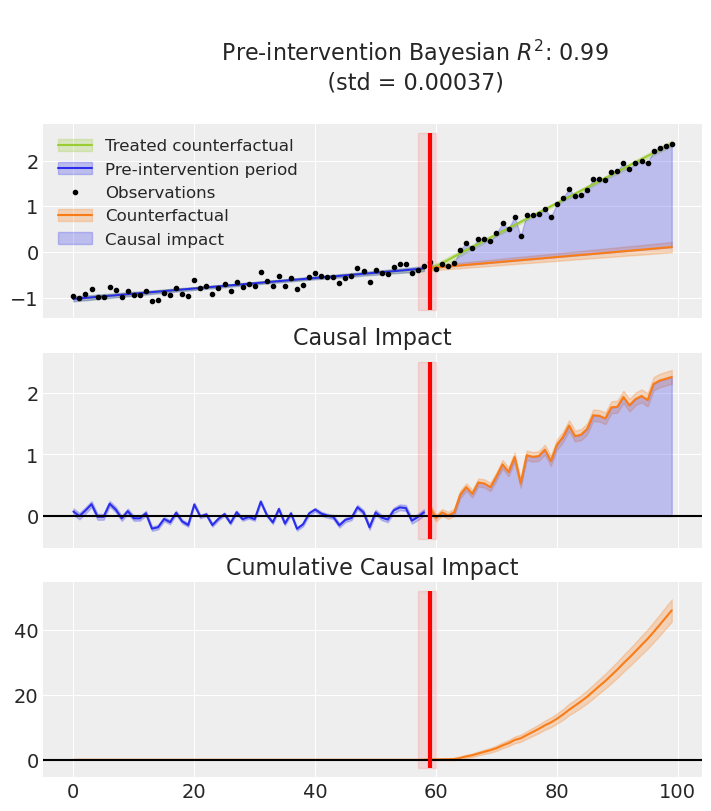

In [9]:
result.plot();

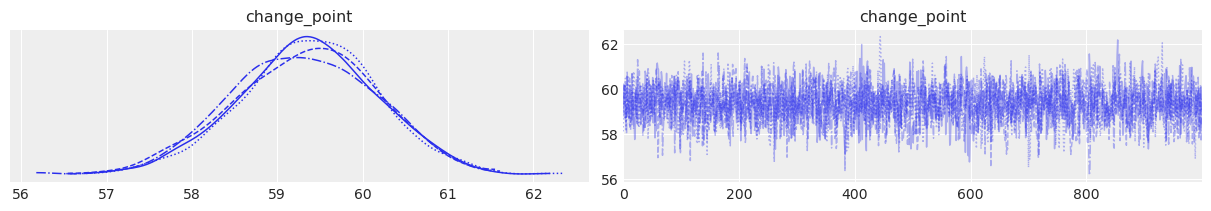

In [11]:
result.plot_change_point()

#### Example 3 : Impulse

In this final example, we'll demonstrate how to apply the InterventionTimeEstimator model to data that display an impulse-like effect. Here how it works under the hood :

$$
\begin{align}
A &\sim \mathcal{N}(0, 5) \\
\lambda &\sim \text{HalfNormal}(0, 5) \\
\mu_{\text{impulse}} &= \sigma(t) \cdot A e^{- \lambda (\text{time} - t)} \\
y &\sim \mathcal{N}(\mu + \mu_{\text{impulse}}, \sigma)
\end{align}
$$

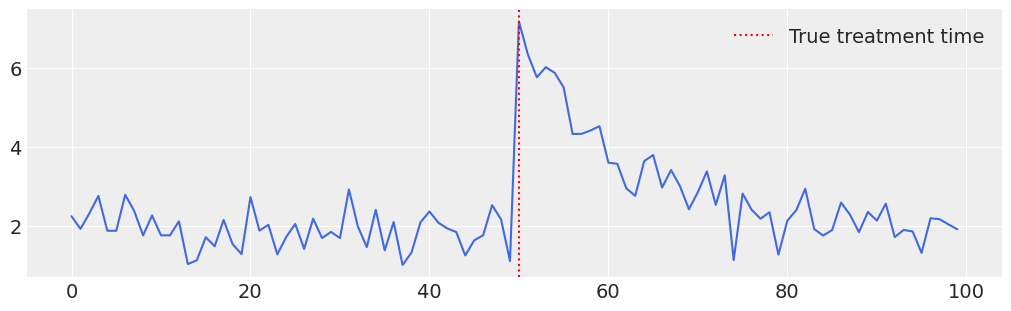

In [13]:
# Generate data ...

np.random.seed(42)
n = 100
t = np.arange(n)

intercept = 2
trend = intercept

# Impulse parameters
t0 = 50
A = 5
decay_rate = 0.1
impulse = np.zeros(n)
impulse[t0:] = A * np.exp(-decay_rate * (t[t0:] - t0))

# Bruit
noise = np.random.normal(0, 0.5, size=n)

# Série finale
y = trend + impulse + noise

df = pd.DataFrame({"y": y, "time": t})

# Plot ...

plt.figure(figsize=(10, 3))
plt.plot(t, y, color="royalblue")
plt.axvline(t0, color="red", linestyle=":", label="True treatment time")
plt.legend()
plt.grid(True)
plt.show();

Remember to set ``treatment_effect_type`` to ``"impulse"``.

In [14]:
model = LinearChangePointDetection(
    cp_effect_type="impulse",
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result = ChangePointDetection(
    data=df,
    time_range=None,
    formula="standardize(y) ~ 1 + time",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, impulse_amplitude, impulse_decay_rate, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
Sampling: [beta, impulse_amplitude, impulse_decay_rate, tau_un, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


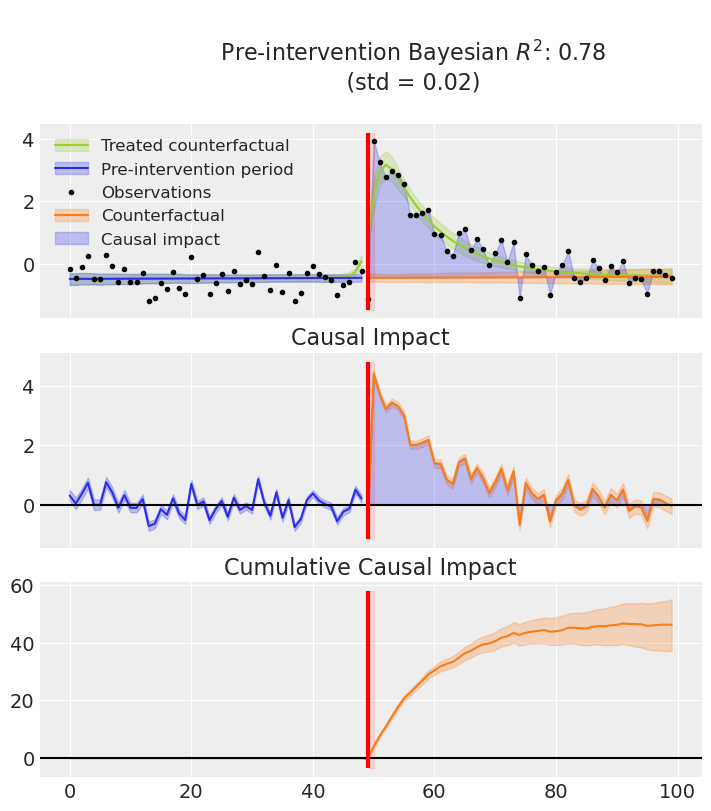

In [15]:
result.plot();

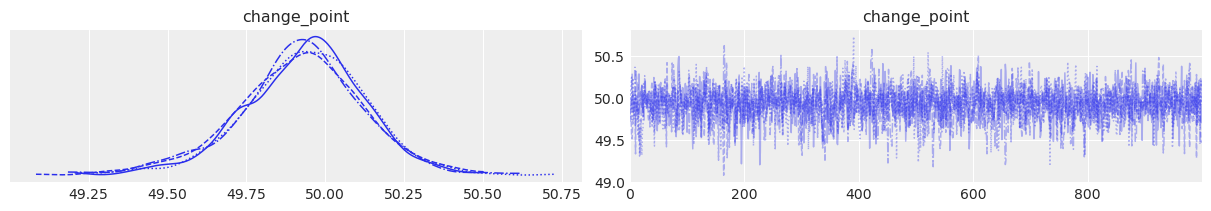

In [16]:
result.plot_change_point()

#### Narrowing the Inference Window

Instead of specifying a treatment_time, you can constrain the inference window by passing a time_range=(start, end) argument, where start and end correspond to the row indices or timestamps of your dataframe:

- `time_range=(80,100)`

or

- `time_range=(pd.to_datetime("2016-01-31"),pd.to_datetime("2018-01-31"))`

This can significantly improve inference speed and robustness, especially when dealing with long or noisy time series.

:::{tip}
If you’re unsure about the intervention period, try starting with ``time_range=None`` and inspect the posterior.
:::

Keeping the same example, if we now increase the noise in the data and reduce the level change, the advantage of using a restricted time_range becomes evident:

In [20]:
# Making the example

n = 100
tau_true = 40
x = np.arange(n)
y = np.where(x >= tau_true, 1.60, 0.0) + np.random.normal(1, 1.30, size=n)
df = pd.DataFrame({"t": x, "y": y})

In [21]:
# First run: unconstrained treatment time — the model scans the entire time axis.
# With noisy data, this leads to a wide posterior and uncertain inference.

model1 = LinearChangePointDetection(
    cp_effect_type="level",
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result1 = ChangePointDetection(
    data=df,
    time_range=None,
    formula="standardize(y) ~ 1 + t",
    model=model1,
)

# Second run: constrain the treatment time to a plausible window (t in [20, 60]).
# This narrows the posterior, improves inference stability, and speeds up sampling.

model2 = LinearChangePointDetection(
    cp_effect_type="level",
    sample_kwargs={"sample_seed": seed, "progressbar": False},
)

result2 = ChangePointDetection(
    data=df,
    time_range=(20, 60),
    formula="standardize(y) ~ 1 + t",
    model=model2,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, level, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, level, tau_un, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, level, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
Sampling: [beta, level, tau_un, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat

Now that we’ve increased the noise, we can already observe issues with sampling. The warning “_The rhat statistic is larger than 1.01 for some parameters_” indicates convergence problems: the model struggles to infer from the data, and the parameters fail to stabilize around their true values. In contrast, the model with a fixed time range does not trigger such warnings.

Looking at the forest plot, the difference becomes even clearer. The model with a given time range not only recovers the true treatment time more reliably, but it also does so with substantially less uncertainty. While the unconstrained model isn't even centered near the correct value, its wide intervals and convergence issues mean that we cannot trust its estimates.

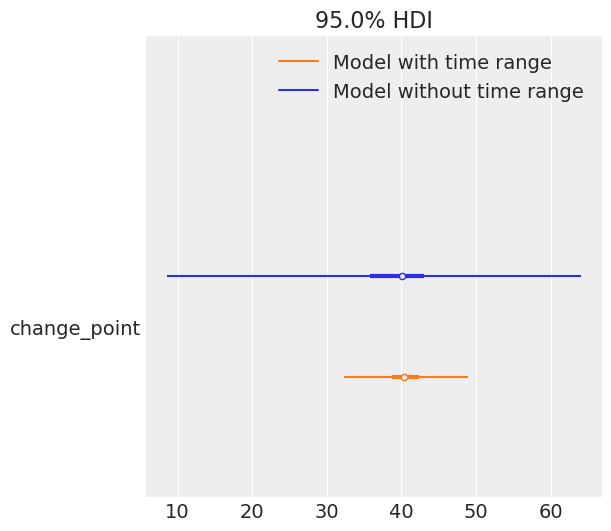

In [22]:
az.plot_forest(
    [result1.idata, result2.idata],
    var_names=["change_point"],
    model_names=["Model without time range", "Model with time range"],
    combined=True,
    hdi_prob=0.95,
);

#### Specifying the effect

The effects also can be specified using a dictionary passed to the `treatment_effect_param` arguments :

```
model = InterventionTimeEstimator(
    treatment_effect_type=["level", "impulse"],
    treatment_effect_param={"impulse":[mu, sigma1, sigma2]}
    )
```

:::{note}
You must provide all parameters if you choose to set them manually. If you leave the list empty or not fully furnished, default priors will be used.
:::

| Effect type | Description | Parameters required |
|-------------|-------------|---------------------|
|`level`| Permanent jump in the time series level | `[mu, sigma]` for N(mu, sigma) |
|`trend`| Change in the trend slope | `[mu, sigma]` for N(mu, sigma) |
|`impulse`| Sudden change with decay | `[mu, sigma1, sigma2]` where:<br> - Amplitude ~ N(mu, sigma1)<br> - decay ~ HalfNormal(sigma2) |


### Summary: How to use ``InterventionTimeEstimator``

1. **Specify the time variable**
    
    Indicate which variable in the formula represents time using the time_variable_name argument.

2. **Select the intervention effect type**

    Choose the expected effect(s) of the intervention: "impulse", "level", or "trend".

3. **Configure priors for each effect**
    
    Either:

    - use default priors or

    - specify custom priors (e.g. ``treatment_effect_param={"impulse": [mu, sigma1, sigma2]}``).

4. **(Optional) Limit the inference window**

    Use ``time_range=(start, end)`` to restrict inference to a specific time interval.

5. **Pass the model to InterruptedTimeSeries**

### Interrupted Time Series (InterruptedTimeSeries) : Real Data Example

In [23]:
# Load Data ...

df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


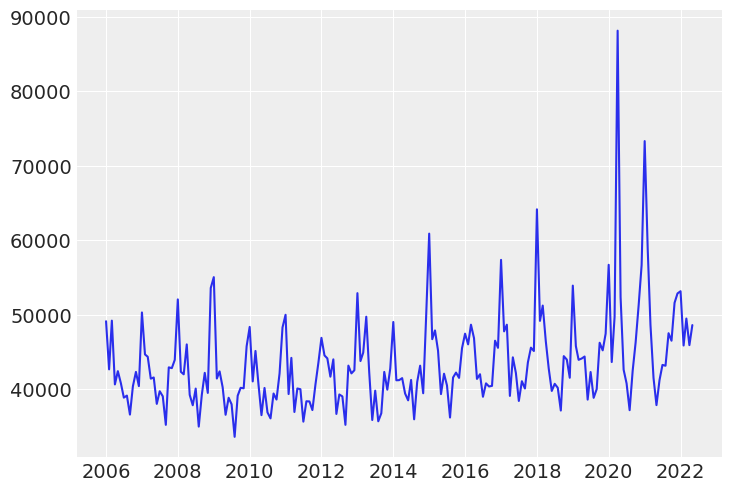

In [24]:
# Visualize the data ...

plt.plot(df.index, df["deaths"]);

Looking at the data, we observe a noticeable increase in the number of deaths between years 2017 and 2019. After this period, the values seem to return to their previous level.

In this example, we will build a model using the "impulse" effect to represent this transient deviation. We won’t specify the exact location of the intervention, instead we will give a time range and hope the model will infer it from the data.

In [29]:
model = LinearChangePointDetection(
    cp_effect_type="impulse",
    sample_kwargs={"random_seed": seed, "progressbar": False},
)

Run the analysis

Optionally, instead of providing a fixed `treatment_time`, we can guide the inference by specifying a time_range as a tuple, for example, restricting the intervention to occur between years 2014 and 2022. Leaving `treatment_time=None` allows the model to search freely over all possible timestamps, but adding a constraint typically speeds up inference and focuses the posterior on plausible regions.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [30]:
result = ChangePointDetection(
    df,
    time_range=(pd.to_datetime("2014-01-01"), pd.to_datetime("2022-01-01")),
    formula="standardize(deaths) ~ 0 + t + C(month) + standardize(temp)",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_un, beta, impulse_amplitude, impulse_decay_rate, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
Sampling: [beta, impulse_amplitude, impulse_decay_rate, tau_un, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


Plot the results

:::{note}

The model estimates the latent time series mu_hat by combining two components:

- `mu`: the part inferred from the user-defined formula (e.g. time + month),

- `mu_in`: the contribution from the intervention effect.

In the plots, we display only `mu` — the baseline prediction based on the formula — to better highlight the causal impact of the intervention. This makes it easier to see how the observed data diverge from what would be expected without the effect.

In contrast, evaluation metrics like R² and standard deviation are computed using `mu_hat`, which includes both the formula and the intervention effect.
As a result, R² may appear higher than what the plots suggest.
:::

(<Figure size 700x800 with 3 Axes>,
 array([<Axes: title={'center': '\n            Pre-intervention Bayesian $R^2$: 0.76\n            (std = 0.017)\n            '}>,
        <Axes: title={'center': 'Causal Impact'}>,
        <Axes: title={'center': 'Cumulative Causal Impact'}>], dtype=object))

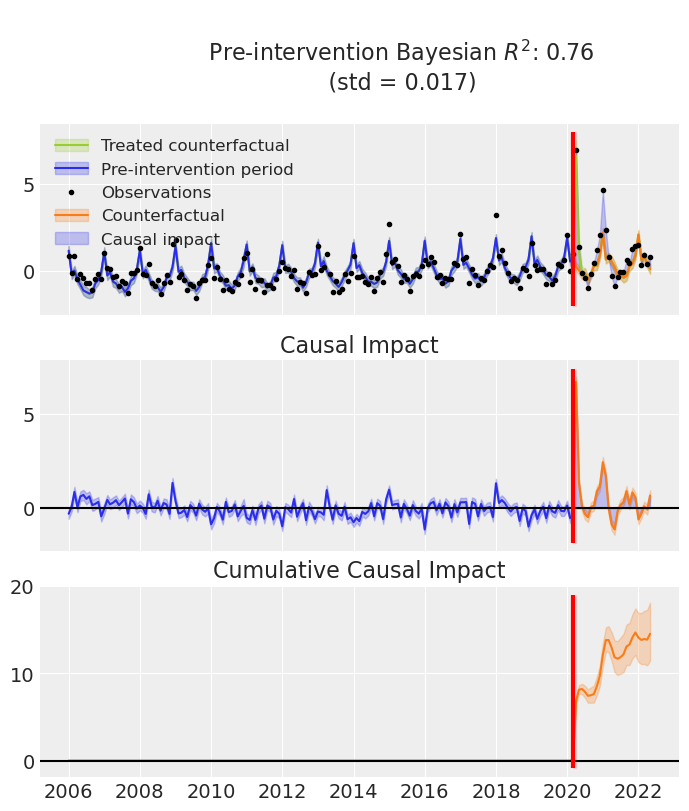

In [31]:
result.plot()

It is also possible to plot the posterior distribution of the changepoint :

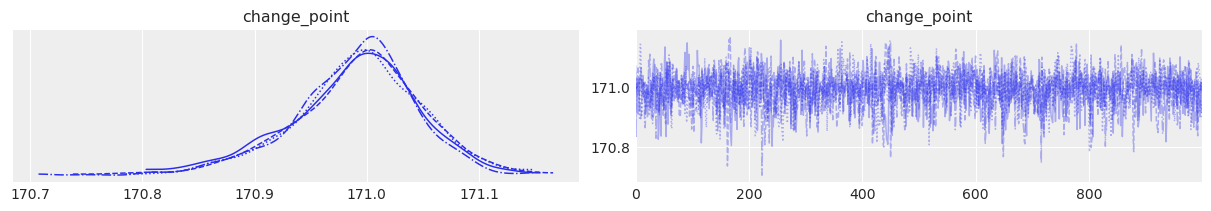

In [32]:
result.plot_change_point();

In [33]:
result.summary()

==================================Pre-Post Fit==================================
Formula: standardize(deaths) ~ 0 + t + C(month) + standardize(temp)
Model coefficients:


KeyError: "'treated_units' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'sample': 4000})"

As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [34]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ts[unit_0],0.542,0.067,0.415,0.666,0.001,0.001,3201.0,3012.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [35]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ts[unit_0],14.535,1.779,11.453,18.109,0.032,0.023,3161.0,3136.0,1.0


### References

- Kay H. Brodersen. Fabian Gallusser. Jim Koehler. Nicolas Remy. Steven L. Scott. "Inferring causal impact using Bayesian structural time-series models." Ann. Appl. Stat. 9 (1) 247 - 274, March 2015. https://doi.org/10.1214/14-AOAS788
- Davis Berlind, Lorenzo Cappello, Oscar Hernan Madrid Padilla. "A Bayesian framework for change-point detection with uncertainty quantification", https://doi.org/10.48550/arXiv.2507.01558